# Import Telemetry class


In [1]:
from TMclass import *
import datetime
fromiso = datetime.datetime.fromisoformat
tdelta = datetime.timedelta
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xml.etree import ElementTree


def flush_many(max_vol, vol_dataset, phi_mode, start, nbits, ndata, level, partition):
    global PHI
    global phi

    def _new_start(start,end):
        start += datetime.timedelta(days=1)
        start = start.replace(hour=3,minute=0,second=0)
        if end > start:
            start = end + datetime.timedelta(hours=1)
        return start
    

    vol0 = max_vol[0]
    vol1 = max_vol[1]
    n0 = int(vol0 // vol_dataset * 0.99)
    n1 = int(vol1 // vol_dataset * 0.99)

    if ndata == -1:
        ndata = phi_mode.raw.n_datasets
    
    print(f'Days needed: {(ndata-n0)//n1+2}')
    kw = phi_mode.compressing(start, nbits = nbits, ndata = n0,level=level); phi.saving(partition,**kw); PHI.saving(partition,**kw)
    # start += datetime.timedelta(days=1)
    start = _new_start(start,kw['end'])

    for i in range((ndata-n0)//n1+1):
        kw = phi_mode.compressing(start, nbits = nbits, ndata = n1,level=level); phi.saving(partition,**kw); PHI.saving(partition,**kw)
        start = _new_start(start,kw['end'])

    return (phi_mode, kw)

PHI = PHI_MEMORY(datetime.datetime.fromisoformat('2022-01-19T23:00:00'))

TM = {'date':[], 'tm_rate':[], 'duration':[]}
TMnew = {'date':[], 'tm_rate':[], 'duration':[]}

with open('../telem.xml') as f:
    tree = ElementTree.parse(f)

for node in tree.iter('PASS'):
    d = datetime.datetime.fromisoformat(node.attrib.get('comment')[:-1]).date()
    if d >= datetime.date(2022,1,1) and d <= datetime.date(2023,1,1):
        TM['date'] += [datetime.datetime.fromisoformat(node.attrib.get('comment')[:-1])]
        TM['tm_rate'] += [float(node.attrib.get('tm_rate'))]
        TM['duration'] += [int(node.attrib.get('duration'))]

with open('../EFECS_M06_V00.xml') as f:
    tree = ElementTree.parse(f)

for node in tree.iter('PASS'):
    d = datetime.datetime.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S").date()
    if d >= datetime.date(2022,1,1) and d <= datetime.date(2023,1,1):
        TMnew['date'] += [datetime.datetime.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S")]
        TMnew['tm_rate'] += [float(node.attrib.get('tm_rate'))]
        TMnew['duration'] += [int(node.attrib.get('duration'))]

TM['date'] = np.asarray(TM['date'])
TM['tm_rate'] = np.asarray(TM['tm_rate'])
TM['duration'] = np.asarray(TM['duration'])

TMnew['date'] = np.asarray(TMnew['date'])
TMnew['tm_rate'] = np.asarray(TMnew['tm_rate'])
TMnew['duration'] = np.asarray(TMnew['duration'])

f = open('phi.itl','r')
lines = f.readlines()

FL = {'date':[], 'flush':[]}

for x in lines:
    temp = x.split(' ')
    if 'PHI_SCI_Flush_VOL' in temp[-1]:
        FL['date'] += [datetime.datetime.fromisoformat(temp[0][:-1])]
        FL['flush'] += [float(temp[-1][19:-2])]
        # print(temp[0][:-1],temp[-1][19:-2])

FL['date'] = np.asarray(FL['date'])
FL['flush'] = np.asarray(FL['flush'])

f = open('phi.itl','r')
lines = f.readlines()

# SV = {'date':[], 'rate':[]}

# for x in lines:
#     temp = x.split(' ')
#     if 'PHI_SCI_Rate' in temp[-1]:
#         SV['date'] += [datetime.datetime.fromisoformat(temp[0][:-1])]
#         SV['rate'] += [float(temp[-1][14:-2])]
#         # print(temp[0][:-1],temp[-1][19:-2])

# SV['date'] = np.asarray(SV['date'])
# SV['rate'] = np.asarray(SV['rate'])

f = open('phi_new.itl','r')
lines = f.readlines()

FLnew = {'date':[], 'flush':[]}

for x in lines:
    temp = x.split(' ')
    if 'PHI_SCI_Flush_VOL' in temp[-1]:
        FLnew['date'] += [datetime.datetime.fromisoformat(temp[0][:-1])]
        FLnew['flush'] += [float(temp[-1][19:-2])]
        # print(temp[0][:-1],temp[-1][19:-2])

FLnew['date'] = np.asarray(FLnew['date'])
FLnew['flush'] = np.asarray(FLnew['flush'])



Leggo il csv come (t,fcp,id), in cui id ha un certo numero di entrate. Creo PHI dal primo orario - 1 giorno o lo creo a mano

In [2]:
PHI = PHI_MEMORY(fromiso('2022-03-05T00:00:00'))

def load_csv(fname):
    import pandas as pd

    dateparse = lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S')

    dur = pd.read_csv('/home/calchetti/Desktop/phi_proc_time.lst')

    cols = ['start','fcp']
    for i in range(35):
        cols.append('FP_'+str(i+1))

    df = pd.read_csv(fname, names=cols, keep_default_na=False, index_col=False, parse_dates=[0], date_parser=dateparse)
    # df = df[df.fcp != 'TMPGAP']
    df.insert(loc=1, column='end', value=None, allow_duplicates=True)
    df = df.query("fcp != 'TMPGAP'")

    old = 0
    for i in df.index:
        
        mask = np.column_stack([dur[col].str.contains(df.fcp[i], na=False) for col in dur])
        duration = dur.loc[mask.any(axis=1)].duration
        if duration.size>1:
            duration = duration.iloc[0]
        
        try:
            duration = float(duration)
        except:
            try:
                temp = duration.values[0]
            except:
                temp = str(duration)
            for j in range(35):
                v = df['FP_'+str(j+1)].loc[i].lstrip('0')
                try:
                    temp = temp.replace('$FP_'+str(j+1),v)
                except:
                    pass
            duration = eval(temp)

        if pd.isnull(df.start[i]):
            df.at[i,'start'] = df.end[old] + tdelta(seconds=20)
        
        if pd.isnull(df.end[i]):
            df.at[i,'end'] = df.at[i,'start'] + tdelta(seconds=duration)
        
        old = i
    
    return df
 

In [118]:
def find_consecutive(obs,did):
    did_int = int(did)
    start_did = np.asarray(list(obs.keys()),dtype=np.int)

    n_datasets = np.asarray([obs[k].raw.n_datasets for k in obs.keys()],dtype=np.int)

    cond = start_did - (did_int) + n_datasets == 0
    obs_i = np.where(cond)[0]

    if len(obs_i) == 1:
        obs_i = obs_i[0]; 
        return list(obs.keys())[obs_i]
    elif len(obs_i) > 1:
        print(f'more observations found with this possible consecutive DID: {did}')

def find_did(obs,did,crop = 500):
    
    start_did = np.asarray(list(obs.keys()),dtype=np.int)
    all_did = np.zeros((6,start_did.size))
    all_did[0] = start_did
    all_did[1] = start_did + crop #crop
    all_did[2] = start_did + 40000000 #pack
    all_did[3] = start_did + 7000 #proc
    all_did[4] = start_did + crop + 40000000 #crop.pack
    all_did[5] = start_did + crop + 7000 #crop.proc
    
    levels = ['raw','raw.crop','raw.pack','proc','raw.pack','proc.crop']

    n_datasets = np.asarray([obs[k].raw.n_datasets for k in obs.keys()],dtype=np.int)
    did_int = int(did)

    cond1 = all_did - (did_int) <= 0
    cond2 = all_did - (did_int) + n_datasets > 0

    obs_i,obs_j = np.where(cond1*cond2)

    if len(obs_i) == 1:
        obs_i = obs_i[0]; 
        obs_j = obs_j[0]; 
        level = levels[obs_i]
        return list(obs.keys())[obs_j], level
    elif len(obs_i) > 1:
        if obs_i[0] in [0,2,4]:
            obs_i = obs_i[0]
            obs_j = obs_j[0]; 
            level = levels[obs_i]
            return list(obs.keys())[obs_j], level
        else:
            print(f'more observations found with this possible DID: {did}')
    elif len(obs_i) == 0:
        print(f'no observations found with this possible DID: {did}')

def run(df,PHI):
    import sys
    import traceback

    obs = {}
    ysize = 2048
    xsize = 2048
    instr = 'HRT'

    for i in range(df.shape[0]):
        fcp = df.iloc[i].fcp

        if fcp == 'FCP-216':#Schedule_Datasets.fcp
            if df.iloc[i+1].fcp != 'FCP-219': #to avoid low latency
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                j = 3
                while df.iloc[i][j] != '':
                    did = df.iloc[i][j]
                    try:
                        try:
                            obs_i, level = find_did(obs,did)
                            kw = obs[obs_i].compressing(t0,ndata=n,nbits=6,level=level)
                        except:
                            print(t0,fcp,'trying with crop did += 400')
                            obs_i, level = find_did(obs,did,400)
                            kw = obs[obs_i].compressing(t0,ndata=n,nbits=6,level=level)
                        
                        PHI.saving(id,**kw)
                    except:
                        print('DID to be flushed not found: '+did,'index:',i)
                        # print(t0)
                    j += 1

        if fcp == 'FCP-217':#Schedule_Consecutive_Datasets.fcp
            if df.iloc[i+1].fcp != 'FCP-219': #to avoid low latency
                did = df.iloc[i].FP_1
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = int(df.iloc[i].FP_2)
                try:
                    obs_i, level = find_did(obs,did)
                    kw = obs[obs_i].compressing(t0,ndata=n,nbits=6,level=level)
                except:
                    print(t0,fcp,'trying with crop did += 400')
                    obs_i, level = find_did(obs,did,400)
                    kw = obs[obs_i].compressing(t0,ndata=n,nbits=6,level=level)
                PHI.saving(id,**kw)
        
        if fcp == 'FCP-401':#Prepare_FDT.fcp
            instr = 'FDT'
        
        if fcp == 'FCP-402':#Prepare_HRT.fcp
            instr = 'HRT'
        
        if fcp == 'FCP-405':#Set_Context_for_MTL_Reentry.fcp
            nout = {'HRT':5, 'FDT':5}
            if int(df.iloc[i].FP_13) < 30:
                nout['HRT'] = 5
            elif int(df.iloc[i].FP_13) >= 30 and int(df.iloc[i].FP_13) < 40:
                nout['HRT'] = 3
            else:
                nout['HRT'] = 2
            
            if int(df.iloc[i].FP_27) < 30:
                nout['FDT'] = 5
            elif int(df.iloc[i].FP_27) >= 30 and int(df.iloc[i].FP_27) < 40:
                nout['FDT'] = 3
            else:
                nout['FDT'] = 2

        if fcp == 'FCP-467':#Set_FPA_Window.fcp
            xsize = (int(df.iloc[i].FP_2) + 2 - int(df.iloc[i].FP_1)) * 2

        if fcp == 'FCP-521':#Acquire_FDT_Flat_Field_Images.fcp
            did = df.iloc[i].FP_3
            t0 = df.iloc[i].start.to_pydatetime()
            t1 = df.iloc[i].end.to_pydatetime()
            n = 9
            cad = 2
            fdt_flat = PHI_MODE(instr)
            kw = fdt_flat.observation(t0,n,cad,(2048,2048,4,6))
            PHI.saving(id,**kw)
            xsize = 2048
        
        if fcp == 'FCP-522':#Process_FDT_Flat_Field_Images.fcp
            did = df.iloc[i].FP_3
            t0 = df.iloc[i].start.to_pydatetime()
            t1 = df.iloc[i].end.to_pydatetime()
            n = 1
            cad = ((t1 - t0)/n).total_seconds()/60
            obs[did] = PHI_MODE(instr)
            kw = obs[did].observation(t0,t1,cad,(2048,2048,4,6))
            PHI.saving(id,**kw)
            xsize = 2048
        
        if fcp == 'FCP-523':#Acquire_HRT_Flat_Field_Images.fcp
            did = df.iloc[i].FP_2
            t0 = df.iloc[i].start.to_pydatetime()
            t1 = df.iloc[i].end.to_pydatetime()
            n = 1
            cad = 50
            hrt_flat = PHI_MODE(instr)
            kw = hrt_flat.observation(t0,n,cad,(2048,2048,4,6))
            PHI.saving(id,**kw)
            xsize = 2048

        if fcp == 'FCP-524':#Process_HRT_Flat_Field_Images.fcp
            did = df.iloc[i].FP_3
            t0 = df.iloc[i].start.to_pydatetime()
            t1 = df.iloc[i].end.to_pydatetime()
            n = 1
            cad = ((t1 - t0)/n).total_seconds()/60
            obs[did] = PHI_MODE(instr)
            kw = obs[did].observation(t0,t1,cad,(2048,2048,4,6))
            PHI.saving(id,**kw)
            xsize = 2048
        
        if fcp == 'FCP-525':#Acquire_HRT_Flat_Field_Images_for_KLL.fcp
            did = df.iloc[i].FP_3
            t0 = df.iloc[i].start.to_pydatetime()
            t1 = df.iloc[i].end.to_pydatetime()
            n = 9
            cad = 2
            hrt_kll = PHI_MODE(instr)
            kw = hrt_kll.observation(t0,n,cad,(2048,2048,4,6))
            PHI.saving(id,**kw)
            xsize = 2048

        if fcp == 'FCP-526':#Process_HRT_Flat_Field_Images_for_KLL.fcp
            did = df.iloc[i].FP_5
            t0 = df.iloc[i].start.to_pydatetime()
            t1 = df.iloc[i].end.to_pydatetime()
            n = 1
            cad = ((t1 - t0)/n).total_seconds()/60
            obs[did] = PHI_MODE(instr)
            kw = obs[did].observation(t0,t1,cad,(2048,2048,4,6))
            PHI.saving(id,**kw)
            xsize = 2048

        if fcp == 'FCP-561':#Perform_FPA_Focus_Scan.fcp
            focus = PHI_MODE(instr)
            t0 = df.iloc[i].start.to_pydatetime()
            t1 = df.iloc[i].end.to_pydatetime()
            cad = ((t1 - t0)/int(df.iloc[i].FP_2)).total_seconds()/60
            kw = focus.observation(t0,t1,cad,(2048,2048,1,1))
            PHI.saving(id,**kw)
        
        if fcp == 'FCP-592':#Calculate_FPA_Dark_Image.fcp
            did = df.iloc[i].FP_4
            t0 = df.iloc[i].start.to_pydatetime()
            t1 = df.iloc[i].end.to_pydatetime()
            n = 2
            cad = 100/60
            obs[did] = PHI_MODE(instr)
            kw = obs[did].observation(t0,n,cad,(ysize,xsize,4,6))
            PHI.saving(id,**kw)
            xsize = 2048
        
        if fcp == 'FCP-595':#Acquire_FPA_PSF_Images.fcp
            did = df.iloc[i].FP_1
            t0 = df.iloc[i].start.to_pydatetime()
            t1 = df.iloc[i].end.to_pydatetime()
            n = 1
            cad = ((t1 - t0)/n).total_seconds()/60
            obs[did] = PHI_MODE(instr)
            kw = obs[did].observation(t0,t1,cad,(2048,2048,1,2))
            PHI.saving(id,**kw)
            xsize = 2048
        
        if fcp == 'FCP-601':#Acquire_Single_Dataset.fcp
            did = df.iloc[i].FP_1
            t0 = df.iloc[i].start.to_pydatetime()
            t1 = df.iloc[i].end.to_pydatetime()
            n = 1
            cad = 100/60
            try:
                obs_i = find_consecutive(obs,did)
                kw = obs[obs_i].observation(t0,n,cad,(ysize,xsize,4,6))
            except:
                obs[did] = PHI_MODE(instr)
                kw = obs[did].observation(t0,n,cad,(ysize,xsize,4,6))
            PHI.saving(id,**kw)
            xsize = 2048

        if fcp == 'FCP-605':#Acquire_Many_Datasets.fcp
            did = df.iloc[i].FP_1
            t0 = df.iloc[i].start.to_pydatetime()
            t1 = df.iloc[i].end.to_pydatetime()
            n = int(df.iloc[i].FP_2)
            cad = int(df.iloc[i].FP_4)/60
            try:
                obs_i = find_consecutive(obs,did)
                kw = obs[obs_i].observation(t0,n,cad,(ysize,xsize,4,6))
            except:
                obs[did] = PHI_MODE(instr)
                kw = obs[did].observation(t0,n,cad,(ysize,xsize,4,6))
            PHI.saving(id,**kw)
            xsize = 2048

        if fcp == 'FCP-703':#Process_Dataset.fcp
            did = df.iloc[i].FP_1
            partialStore = int(df.iloc[i].FP_3)
            t0 = df.iloc[i].start.to_pydatetime()
            t1 = df.iloc[i].end.to_pydatetime()
            n = 1
            try:
                obs_i, level = find_did(obs,did)
                kw = obs[obs_i].processing(t0,ndata=n,nout=nout[instr],partialStore=partialStore,level=level)
            except:
                print(t0,fcp,'trying with crop did += 400')
                obs_i, level = find_did(obs,did,400)
                kw = obs[obs_i].processing(t0,ndata=n,nout=nout[instr],partialStore=partialStore,level=level)
            PHI.saving(id,**kw)
        
        if fcp == 'FCP-704':#Pack_Dataset.fcp
            did = df.iloc[i].FP_1
            t0 = df.iloc[i].start.to_pydatetime()
            t1 = df.iloc[i].end.to_pydatetime()
            n = 1
            try:
                obs_i, level = find_did(obs,did)
                kw = obs[obs_i].packing(t0,ndata=n,level=level)
            except:
                print(t0,fcp,'trying with crop did += 400')
                obs_i, level = find_did(obs,did,400)
                kw = obs[obs_i].packing(t0,ndata=n,level=level)
            PHI.saving(id,**kw)
        
        if fcp == 'FCP-706':#Crop_dataset.fcp
            did = df.iloc[i].FP_1
            new_did = df.iloc[i].FP_2
            t0 = df.iloc[i].start.to_pydatetime()
            t1 = df.iloc[i].end.to_pydatetime()
            n = 1
            diff = int(new_did) - int(did)
            crop = [int(df.iloc[i].FP_6) - int(df.iloc[i].FP_5) + 1, int(df.iloc[i].FP_4) - int(df.iloc[i].FP_3) +1]
            obs_i, level = find_did(obs,did,diff)
            kw = obs[obs_i].cropping(t0,crop=crop,ndata=n,level=level)
            PHI.saving(id,**kw)
        
        if fcp == 'FCP-709' or fcp == 'FCP-709B':#Pack_Many_Datasets.fcp
            did = df.iloc[i].FP_1
            t0 = df.iloc[i].start.to_pydatetime()
            t1 = df.iloc[i].end.to_pydatetime()
            n = int(df.iloc[i].FP_2)
            try:
                obs_i, level = find_did(obs,did)
                kw = obs[obs_i].packing(t0,n,level=level)
                PHI.saving(id,**kw)
            except:
                # print(i)
                # print(did)
                print(t0,fcp,'trying with crop did += 400')
                obs_i, level = find_did(obs,did,400)
                kw = obs[obs_i].packing(t0,n,level=level)
                PHI.saving(id,**kw)
            
        if fcp == 'FCP-710' or fcp == 'FCP-710B':#Crop_many_datasets.fcp
            did = df.iloc[i].FP_1
            new_did = df.iloc[i].FP_4
            t0 = df.iloc[i].start.to_pydatetime()
            t1 = df.iloc[i].end.to_pydatetime()
            n = int(df.iloc[i].FP_2)
            diff = int(new_did) - int(did)
            crop = [int(df.iloc[i].FP_8) - int(df.iloc[i].FP_7) + 1, int(df.iloc[i].FP_6) - int(df.iloc[i].FP_5) +1]
            obs_i, level = find_did(obs,did,diff)
            kw = obs[obs_i].cropping(t0,crop=crop,ndata=n,level=level)
            PHI.saving(id,**kw)
            
        if fcp == 'FCP-903':#Select_Partitions.fcp
            id = int(df.iloc[i].FP_1)
        
        if fcp == 'FCP-980':#Format_NANDFS_Partition.fcp
            t0 = df.iloc[i].start.to_pydatetime()
            PHI.format_partition(int(df.iloc[i].FP_1),t0)

    return PHI, obs




In [129]:
fname192 = '/home/calchetti/MPStemp/PHI_TMtool/stp/stp192.csv'
df192 = load_csv(fname192)

fname193 = '/home/calchetti/MPStemp/PHI_TMtool/stp/stp193.csv'
df193 = load_csv(fname193)

fname194 = '/home/calchetti/MPStemp/PHI_TMtool/stp/stp194.csv'
df194 = load_csv(fname194)

fname195 = '/home/calchetti/MPStemp/PHI_TMtool/stp/stp195.csv'
df195 = load_csv(fname195)

fname196 = '/home/calchetti/MPStemp/PHI_TMtool/stp/stp196.csv'
df196 = load_csv(fname196)

fname197 = '/home/calchetti/MPStemp/PHI_TMtool/stp/stp197.csv'
df197 = load_csv(fname197)

fname198 = '/home/calchetti/MPStemp/PHI_TMtool/stp/stp198.csv'
df198 = load_csv(fname198)

fname199 = '/home/calchetti/MPStemp/PHI_TMtool/stp/stp199.csv'
df199 = load_csv(fname199)

fname200 = '/home/calchetti/MPStemp/PHI_TMtool/stp/stp200.csv'
df200 = load_csv(fname200)

fname201 = '/home/calchetti/MPStemp/PHI_TMtool/stp/stp201.csv'
df201 = load_csv(fname201)

df = pd.concat([df192,df193,df194,df195,df196,df197,df198,df199,df200,df201])

/home/calchetti/miniconda3/envs/dancalc/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


no observations found with this possible DID: 0222251001
2022-03-06 22:38:03 FCP-216 trying with crop did += 400
no observations found with this possible DID: 0222251001
DID to be flushed not found: 0222251001 index: 70
2022-03-22 15:07:52 FCP-216 trying with crop did += 400
DID to be flushed not found: 0223221001 index: 898
2022-04-06 01:17:34 FCP-709 trying with crop did += 400
no observations found with this possible DID: 0204010801
2022-04-06 02:33:44 FCP-709 trying with crop did += 400
2022-04-06 10:57:44 FCP-216 trying with crop did += 400
2022-04-06 10:57:44 FCP-216 trying with crop did += 400
2022-04-08 00:39:14 FCP-216 trying with crop did += 400
2022-04-10 00:13:26 FCP-217 trying with crop did += 400
no observations found with this possible DID: 0244010801
2022-04-10 00:14:00 FCP-217 trying with crop did += 400
no observations found with this possible DID: 0244010806
2022-04-11 00:13:26 FCP-217 trying with crop did += 400
no observations found with this possible DID: 02040208

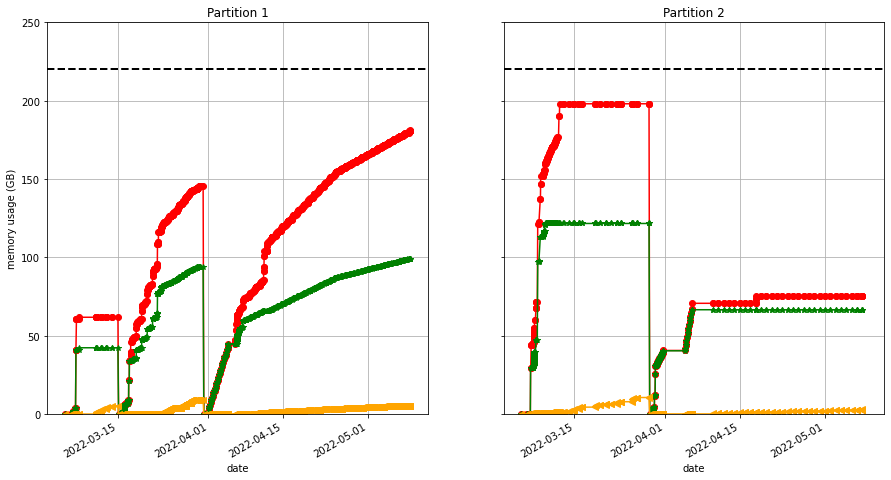

In [130]:
PHI = PHI_MEMORY(fromiso('2022-03-05T00:00:00'))

PHI, obs = run(df,PHI)

plot_tot(PHI,ylim=(0,250))
